In [6]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

In [2]:
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-11-24 18:18:17.656976: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-24 18:18:17.660105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-24 18:18:17.687158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 18:18:17.687557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.755GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-24 18:18:17.687611: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-24 18:18:17.836027: I tensorflow/stream_executor/platform

In [49]:
datagenerator = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    #horizontal_flip=True,
    #rotation_range=20,
    #vertical_flip=True,
    #width_shift_range=0.1,
    #featurewise_center=True,
    samplewise_center=True,
    #samplewise_std_normalization=True,
    #brightness_range=[0.90,1.25],
    #fill_mode='nearest'
)

In [50]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('../train/', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=True)

# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('../valid/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False)

# load and iterate test dataset
test_data = datagenerator.flow_from_directory('../test/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 148.7313 and the minimum is -254.9949
The mean value of the pixels is -0.0000 and the standard deviation is 56.1864


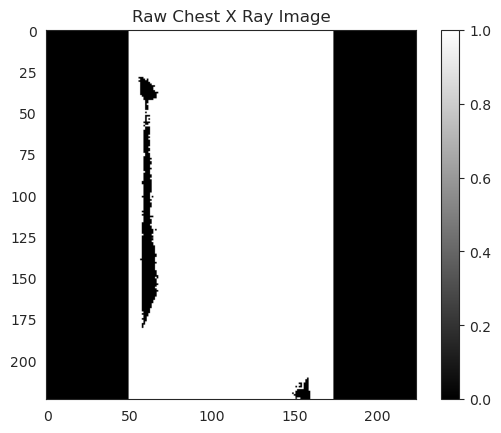

In [52]:
#sns.set_style('white')
generated_image, label = train_data.__getitem__(3)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [15]:
pre_trained_model_resnet152 = ResNet152(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

In [17]:
# Some weights in later layers are unfreezed
for layer in pre_trained_model_resnet152.layers:
    layer.trainable=False

tf.random.set_seed(202)

model = tf.keras.models.Sequential([
    pre_trained_model_resnet152,
    Flatten(),    
    Dense(512,activation="relu"),
    Dropout(0.4),
    Dense(256,activation="relu"),
    Dropout(0.4),
    Dense(128, activation='relu'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 1000)              60419944  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [19]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data  
)

Epoch 1/5
82/82 [==============================] - 481s 6s/step - loss: 0.6657 - accuracy: 0.8263 - val_loss: 0.5710 - val_accuracy: 0.7989
Epoch 2/5
82/82 [==============================] - 440s 5s/step - loss: 0.5456 - accuracy: 0.8016 - val_loss: 0.5176 - val_accuracy: 0.7989
Epoch 3/5
82/82 [==============================] - 439s 5s/step - loss: 0.4917 - accuracy: 0.8209 - val_loss: 0.5088 - val_accuracy: 0.7989
Epoch 4/5
82/82 [==============================] - 442s 5s/step - loss: 0.4523 - accuracy: 0.8358 - val_loss: 0.5056 - val_accuracy: 0.7989
Epoch 5/5
82/82 [==============================] - 441s 5s/step - loss: 0.4405 - accuracy: 0.8457 - val_loss: 0.5070 - val_accuracy: 0.7989


In [20]:
model.evaluate(test_data)

27/27 [==============================] - 182s 7s/step - loss: 0.5145 - accuracy: 0.7998


[0.5145048499107361, 0.7997685074806213]